## Project: **Finding Lane Lines on the Road** 

In [24]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images    
`cv2.cvtColor()` to grayscale or change color    
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

In [25]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=15):
    """
    This function draws `lines` with `color` and `thickness`.    
    
    Lines are drawn on the image inplace (mutates the image).
    
    Equations
    m = (y2-y1)/(x2-x1)
    y = mx + b
    b = y - mx = y - x(y2-y1)/(x2-x1)
    """
    if lines is None:
        return img
    
    # separate line segments into right and left
    left_lines = []
    right_lines = []
    width, height, depth = img.shape
    for line in lines:
        for line_list in line:
            x1,y1,x2,y2 = line_list
            m = float(y2-y1)/(x2-x1)
            
            intercept = calc_intercept(x1,y1,x2,y2, m)
            y1 = int(width * 0.63)
            x1 = int((y1 - intercept) / m)
            y2 = int(width)
            x2 = int((y2 - intercept) / m)
                    
            if m < 0: #left lanes
                left_lines.append(line)
                cv2.line(img, (x1, y1), (x2, y2), (255, 0, 0), thickness)
            else: #right lanes (m > 0)
                right_lines.append(line)
                cv2.line(img, (x1, y1), (x2, y2), (255, 0, 175), thickness)
              
def calc_intercept(x1,y1,x2,y2, slope):
    """ 
    Calculates the intercept of line y = slope * x + intercept 
        
    where x, y in the center of the line
    """
    x = (x1 + x2) / 2
    y = (y1 + y2) / 2
    return y - slope * x


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, A=0.8, B=1., L=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, A, img, B, L)

img = mpimg.imread('test_images/solidWhiteCurve.jpg')
pipeline_process(img)

## Build a Lane Finding Pipeline



#### Pipeline Initiate Data

In [26]:
kernel_size = 3
low_threshold = 64 # Define our parameters for Canny and apply
high_threshold = 192 # Define our parameters for Canny and apply


##### Define the Hough transform parameters
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 100 #minimum number of pixels making up a line
max_line_gap = 160    # maximum gap in pixels between connectable line segments

#### Building The Image & Video Processing Pipeline function

In [27]:
def build_pipeline(image):
    h, w, d = image.shape
    vertices = np.array([[w*0.125, h], [w*0.475, h*0.59], [w*0.52, h*0.59], [w*0.95, h]], dtype=np.int32)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (20, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, low_threshold, high_threshold)
    roi = region_of_interest(edges, [vertices])
    roi2 = region_of_interest(gray, [vertices])
    lines = hough_lines(roi2, rho, theta, threshold, min_line_len, max_line_gap)
    
    #Scanner Checker
    if(scanner==True):     
        image = region_of_interest(image, [vertices]) #scanner shape
        scanner_edges = canny(image, low_threshold, high_threshold)
        scanner_lines = hough_lines(scanner_edges, rho, theta, threshold, min_line_len, max_line_gap)
        
        
    result = weighted_img(image, lines, 0.9, 0.9)
    return result

## Test on Videos
We can test our solution on provided videos:   
`solidWhiteRight.mp4`   
`solidYellowLeft.mp4`    
`challenge.mp4`

In [28]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML, display

#### Video Pipeline Generator & Video Loader Function

In [29]:
def video_generator(input,output,filter):
    clip = VideoFileClip(input)
    white_clip = clip.fl_image(filter) #NOTE: this function expects color images!!
    %time white_clip.write_videofile(output, audio=False)
    

def video_loader(header_text,ori_video,video,scanner_shape):
    display(HTML('<h2 style="text-align:center;">' + header_text + '</h2>' +
                 '<video width="320" height="180" controls><source src="' + ori_video + '"></video>' +
                 '<video width="320" height="180" controls><source src="' + video + '"></video>' +
                 '<video width="320" height="180" controls><source src="' + scanner_shape + '"></video>'))

#### Video Data

In [30]:
video_data = [['White Challenge','solidWhiteRight.mp4','white.mp4','whiteshape.mp4'],
             ['Yellow Challenge','solidYellowLeft.mp4','yellow.mp4','yellowshape.mp4'],
             ['Extra Challenge','challenge.mp4','extra.mp4','extrashape.mp4']] # Optional Challenge

#Test Code , will remove soon
scanner = False
video_generator(video_data[2][1],video_data[2][2],build_pipeline)

#### Generate Pipeline on Video And Display All Video

In [31]:
for i in video_data:    
    scanner = False
    video_generator(i[1],i[2],build_pipeline)
    scanner = True
    #video_generator(i[1],i[3],build_pipeline)
    video_loader(i[0],i[1],i[2],i[3])

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:02<00:00, 77.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 3.15 s


[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:09<00:00, 73.18it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 9.56 s


[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:05<00:00, 39.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 6.55 s


## Test Images
**Test on images before you try the videos.**

In [32]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

#### Process Of Building Pipeline In Image

In [33]:
def showimg(subplace, title, _img):
    plt.subplot(*subplace)
    plt.title(title)
    if len(_img.shape) == 3:
        plt.imshow(_img)
    else:
        plt.imshow(_img, cmap='gray')
        
def pipeline_process(image):
    h, w, _ = image.shape
    vertices = np.array([[w*0.125, h], [w*0.475, h*0.59], [w*0.52, h*0.59], [w*0.95, h]], dtype=np.int32)
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    yellow = cv2.inRange(hsv, (50, 80, 80), (25, 255, 255))
    white = cv2.inRange(hsv, (0, 0, 180), (255, 25, 255))
    gray = cv2.bitwise_or(yellow, white)
    edges = canny(gray, low_threshold, high_threshold)
    roi = region_of_interest(edges, [vertices])
    roi2 = region_of_interest(gray, [vertices])
    lines = hough_lines(roi2, rho, theta, 50, min_line_len, max_line_gap)
    result = weighted_img(image, lines, 0.9, 0.9)

    #Scanner checker
    scanner_shape = region_of_interest(image, [vertices])
    scanner_edges = canny(scanner_shape, low_threshold, high_threshold)
    scanner_lines = hough_lines(scanner_edges, rho, theta, threshold, min_line_len, max_line_gap)
    scanner = weighted_img(scanner_shape, lines, 0.9, 0.9)

    plt.figure(figsize=[20, 13])    
    for i, img in enumerate(['scanner_shape', 'scanner_edges', 'scanner_lines', 'scanner']):
        showimg((2, 2, i+1), img, eval(img))
        
    plt.figure(figsize=[20, 13])
    for i, img in enumerate(['hsv', 'yellow', 'white', 'gray', 'edges', 'roi', 'roi2', 'lines','result']):
        showimg((3, 3, i+1), img, eval(img))


#### Generate Pipeline On Images And Display All The Process

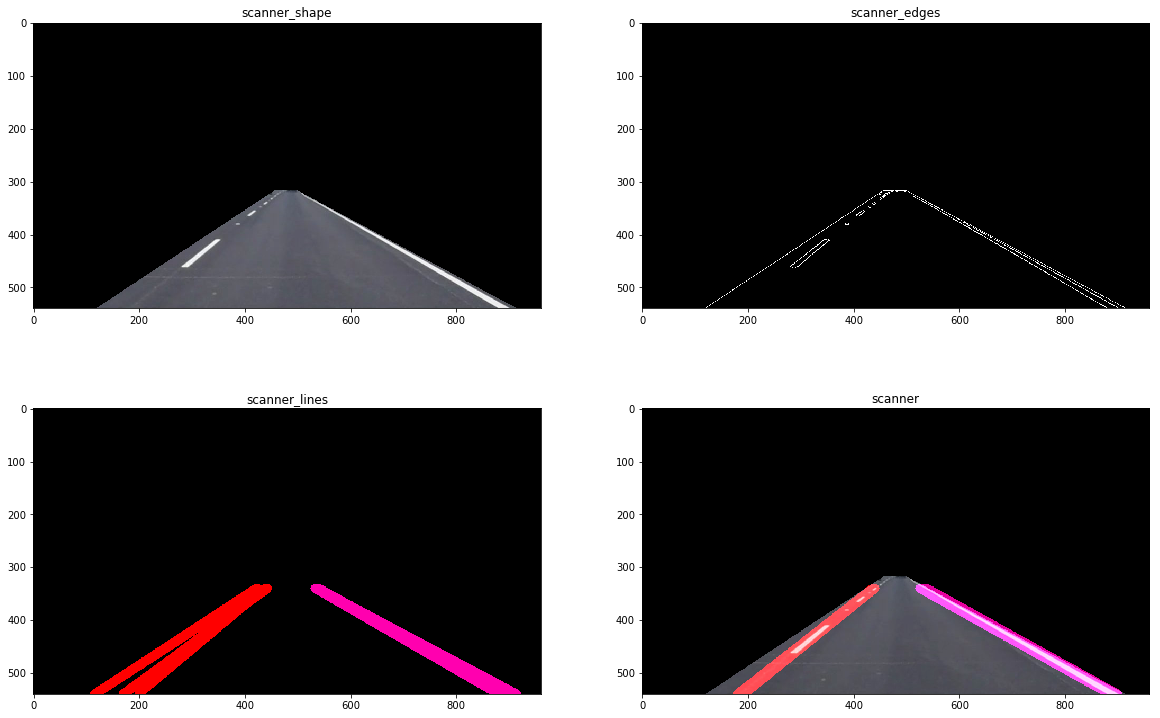

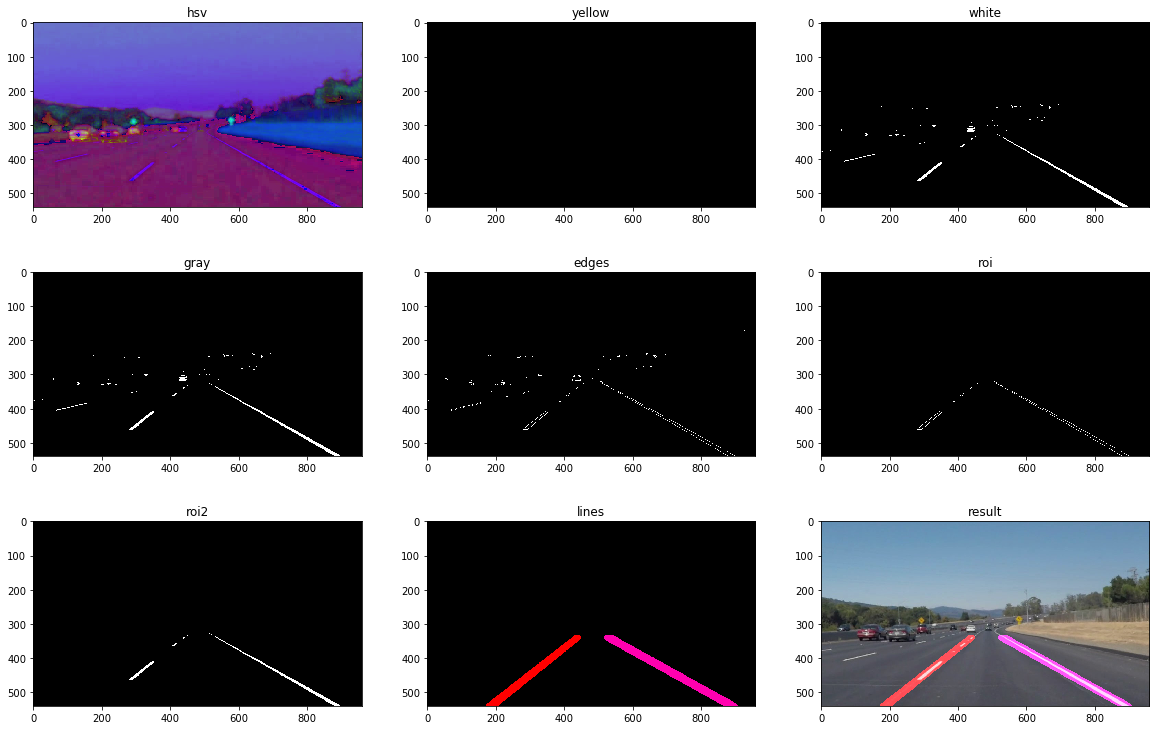

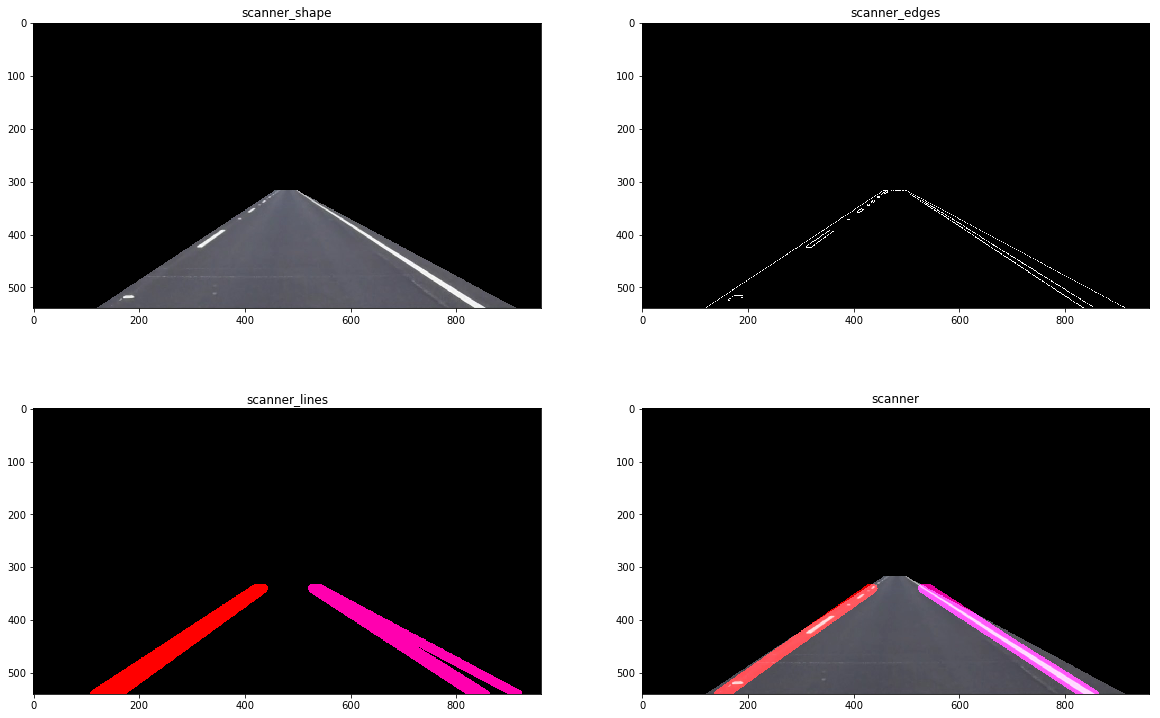

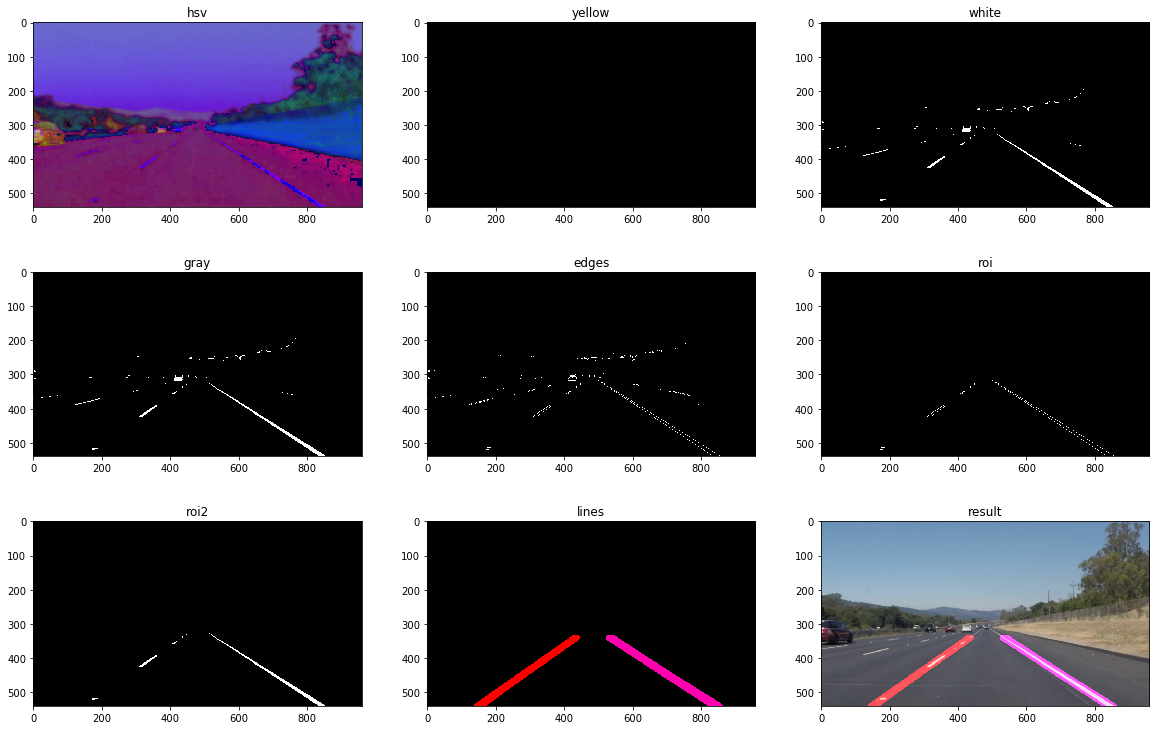

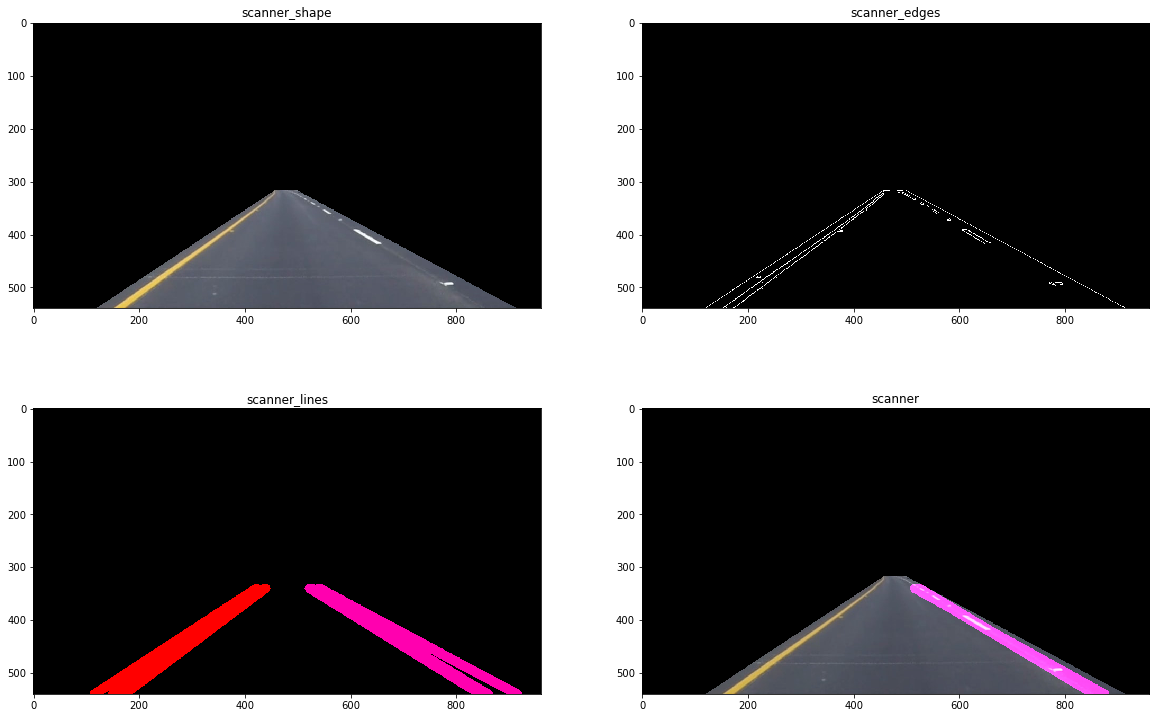

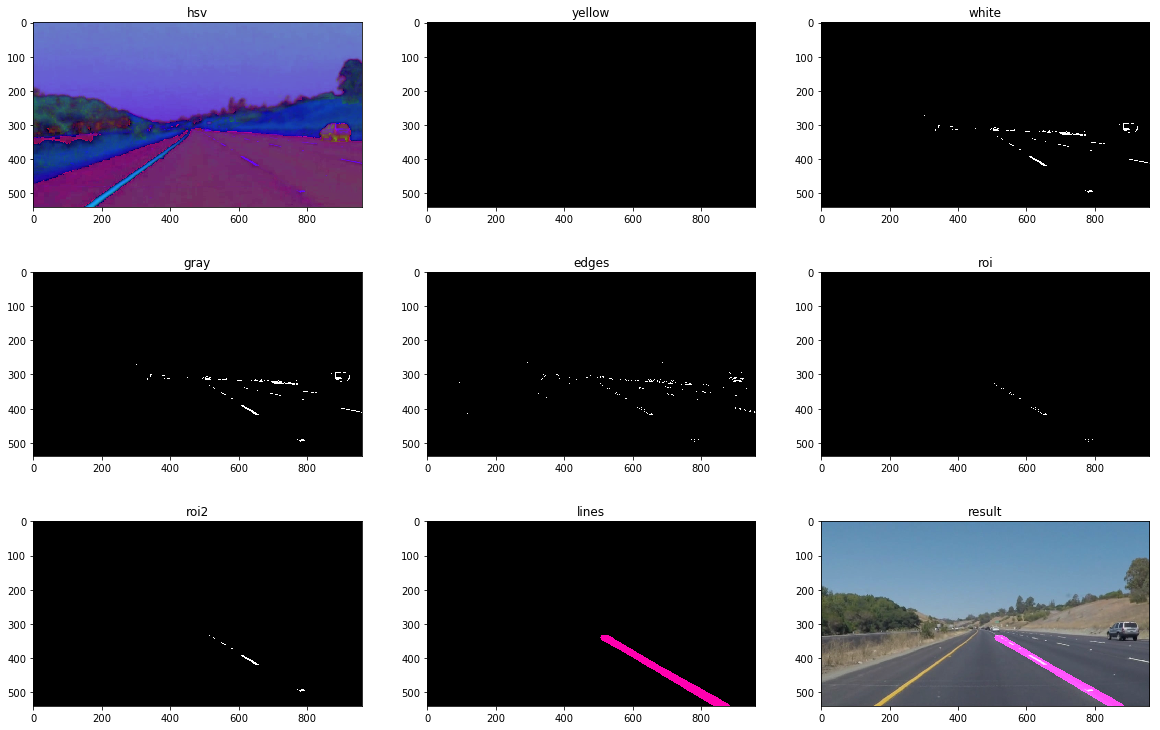

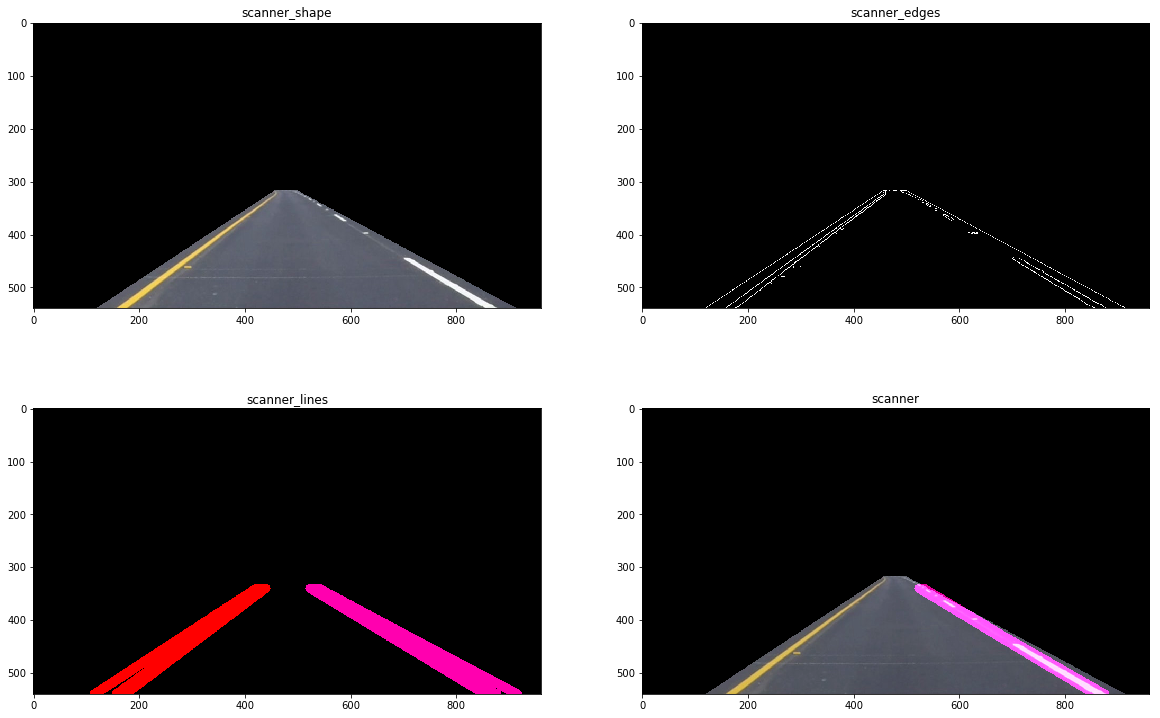

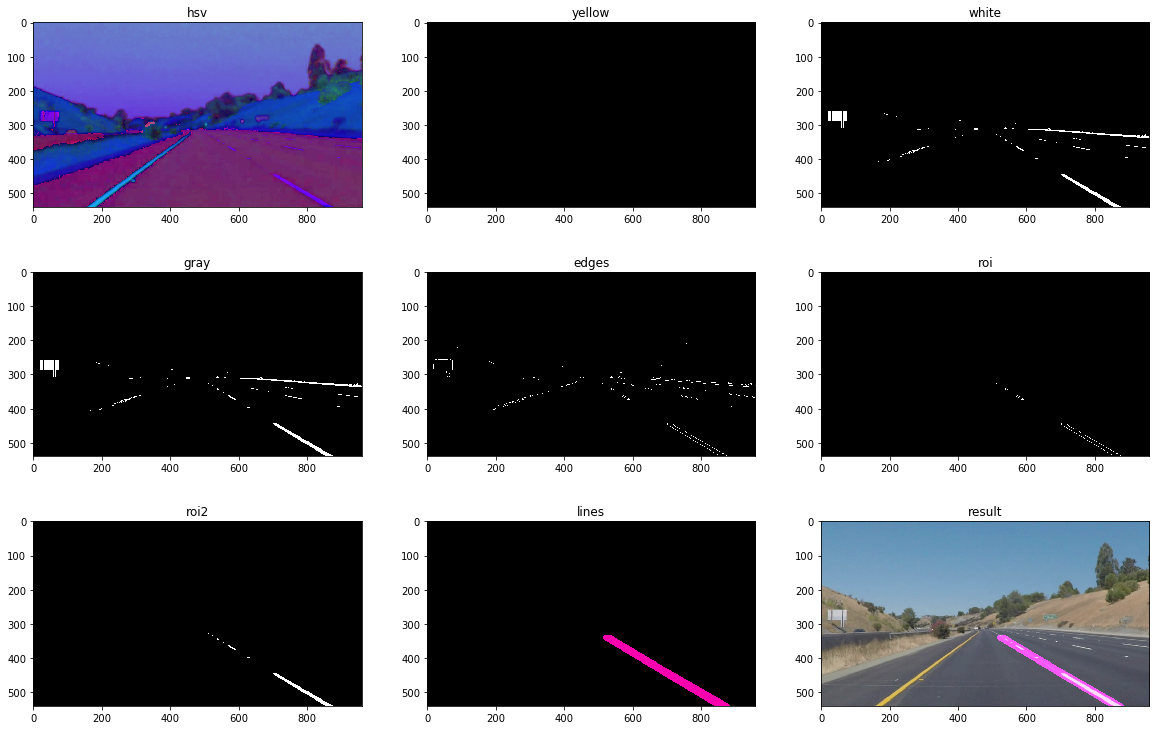

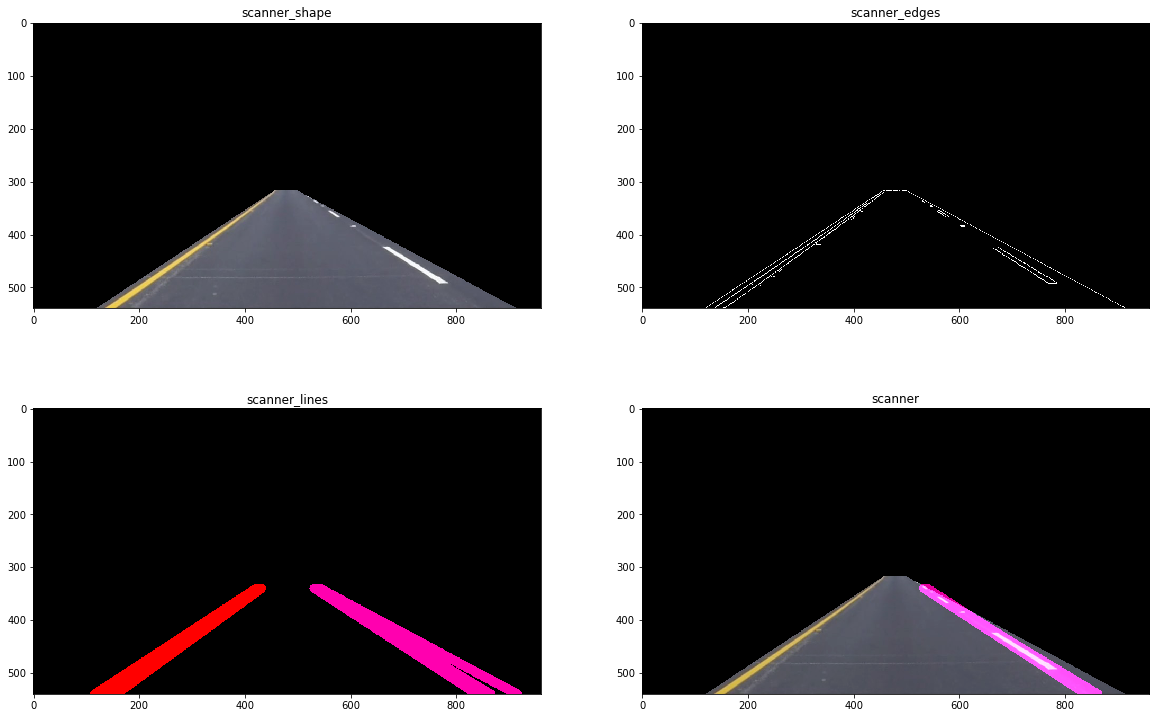

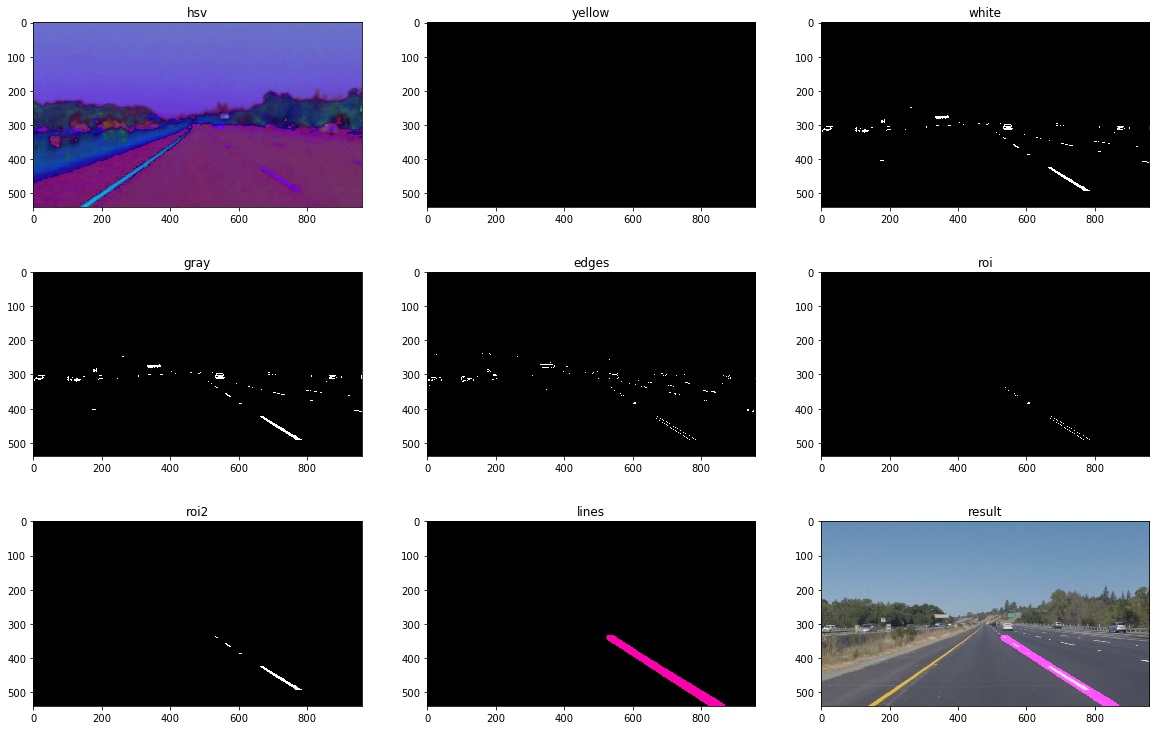

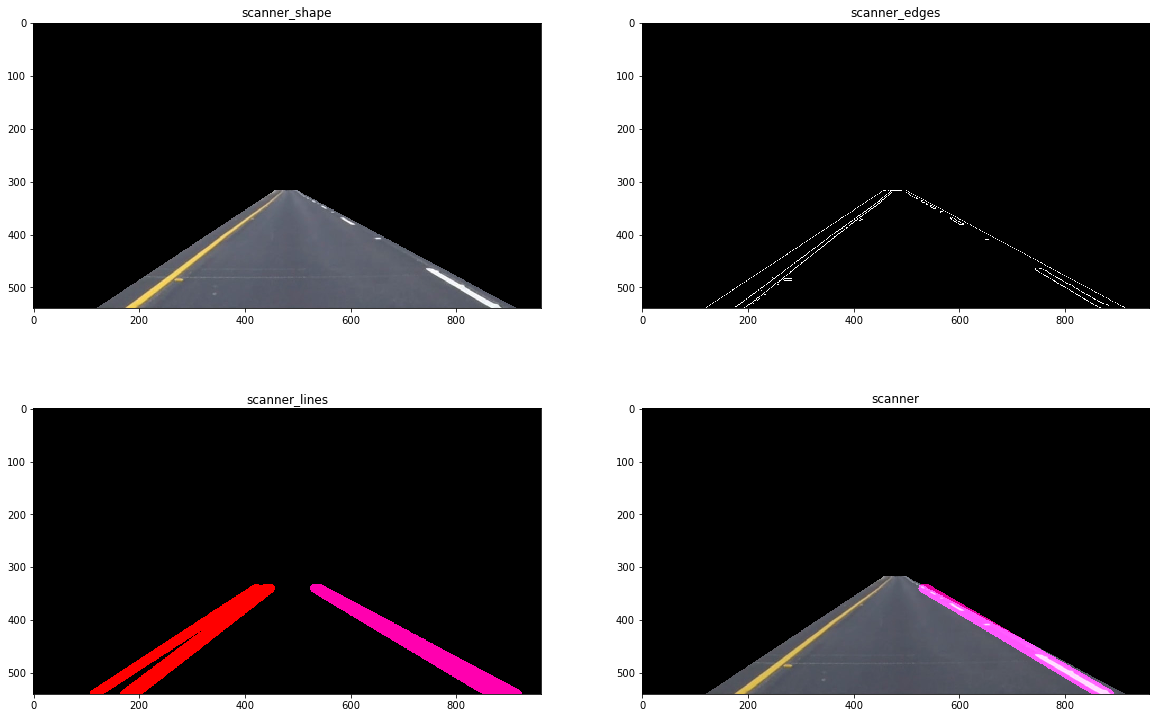

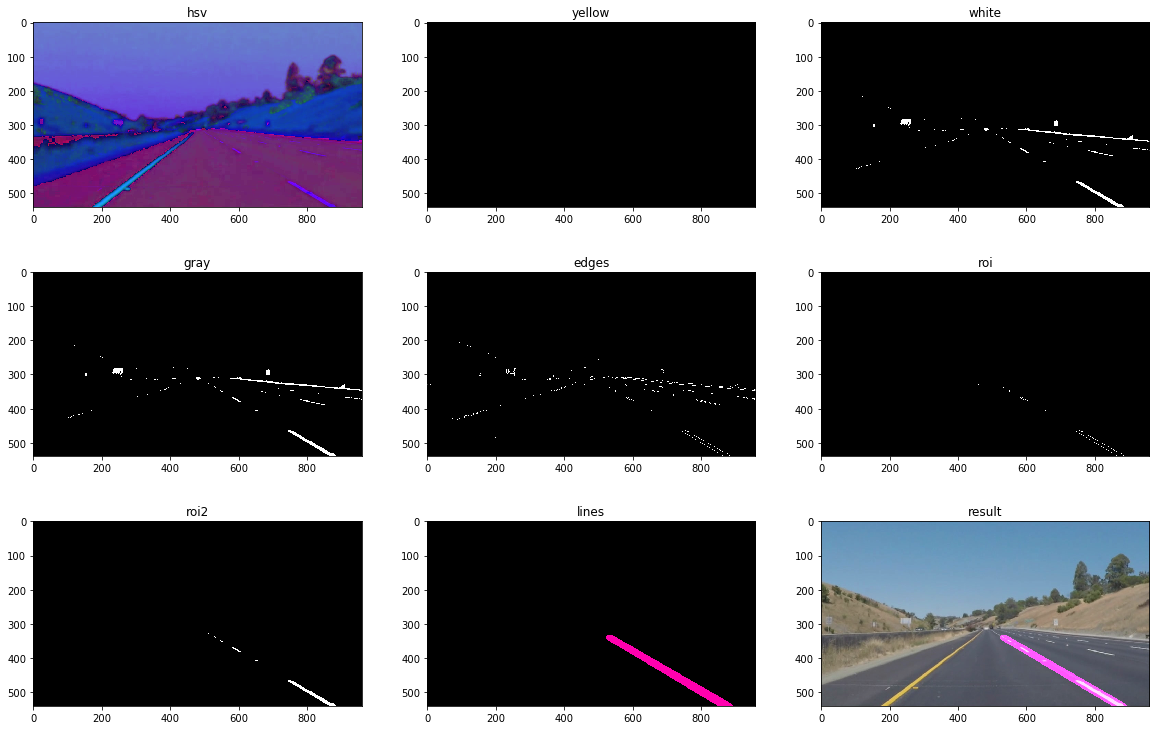

In [34]:
for test_image in os.listdir("test_images/"):
    img = mpimg.imread('test_images/' + test_image)
    pipeline_process(img)

### Reflection
1. Describe your pipeline. As part of the description, explain how you modified the draw_lines() function.
My pipeline consisted of 8 Steps: 
1.	Converted Image to HSV
2.	Use cv2.inRange() to find the colors within the specified boundaries for yellow
3.	Use cv2.inRange() again to find the colors within the specified boundaries for white
4.	Calculates the per-element bit-wise disjunction of two arrays or an array and a scalar with bitwise_or(), so it could detect white and yellow lines
5.	Using the Canny Edge Algorithm to find the edges in the image. The low and high thresholds are set to 64 and 192 respectively. 
6.	Constrain Area of Interest for two times
7.	Applied Hough Transform to find line segments. 
8.	Modified the draw_lines() function in order to draw a single line on the left(slope<0) and right lanes(slope>0)
<img src="pipeline.png">
 
#### Identify potential shortcomings with your current pipeline
1.	My pipeline has trouble dealing with more complicated situations. It isn’t identified the lines stable for the challenge video.
2.	The curve the polygon might mask run out the lines.
3.	The lines are flashing during the curve.

#### Suggest possible improvements to your pipeline
1.	Create a more robust algorithm that is able to adapt to different scenarios.
2.	Make prediction on turning angle of the car.
3.	Write a calibration function to improve the line detection.

